In [1]:
# ===============================
# Cell 1 — Cấu hình & đường dẫn
# ===============================
# - Thiết lập kích thước ảnh và lưới cắt.
# - Seed ngẫu nhiên (nếu cần).
# - Cấu trúc thư mục dự án, TỰ TẠO nếu thiếu.

import os, json, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- Kích thước ảnh đích & lưới mảnh ---
WIDTH, HEIGHT = 600, 360          # Ảnh sau chuẩn hóa
TILE = 120                         # Mỗi mảnh 120x120 (vuông)
COLS, ROWS = WIDTH // TILE, HEIGHT // TILE   # 5 cột x 3 hàng
N_TILES = COLS * ROWS                           # 15 mảnh

# --- Seed toàn cục (chỉ dùng nếu bạn muốn tái lập); ta không dùng mặc định ---
SEED = 2025
RNG = np.random.default_rng(SEED)

# --- Đuôi file ảnh cho phép (không phân biệt hoa/thường) ---
ALLOWED_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".tif", ".tiff", ".gif"}

def _ensure_dirs(*paths):
    """Tạo thư mục nếu chưa có (idempotent/an toàn)."""
    for p in paths:
        os.makedirs(p, exist_ok=True)

def _resolve_project_paths():
    """
    Tự nhận diện cây thư mục:
    - Nếu notebook nằm trong ./code -> dùng ../images
    - Nếu không có -> thử ./images
    - Nếu cả hai chưa có -> tạo ../images
    """
    cwd = os.getcwd()
    cand_1_images = os.path.abspath(os.path.join(cwd, "..", "images"))
    cand_2_images = os.path.abspath(os.path.join(cwd, "images"))
    if os.path.isdir(cand_1_images):
        images_root = cand_1_images
    elif os.path.isdir(cand_2_images):
        images_root = cand_2_images
    else:
        images_root = cand_1_images  # mặc định tạo ở ../images
        os.makedirs(images_root, exist_ok=True)

    root = os.path.abspath(os.path.join(images_root, ".."))
    return root, images_root

# --- Khởi tạo đường dẫn chuẩn ---
ROOT, IMAGES = _resolve_project_paths()
DIR_ORIGIN   = os.path.join(IMAGES, "origin")      # ảnh gốc (bạn bỏ vào đây)
DIR_RESIZE   = os.path.join(IMAGES, "resize")      # ảnh đã chuẩn hóa 600x360
DIR_PROBLEM  = os.path.join(IMAGES, "problem")     # ảnh sau xáo trộn
DIR_TASK1    = os.path.join(DIR_PROBLEM, "task1")  # random 14 mảnh, giữ (0,0)
DIR_TASK2    = os.path.join(DIR_PROBLEM, "task2")  # random all 15 mảnh
DIR_SLOVED   = os.path.join(IMAGES, "sloved")      # (để trống, dùng solve sau này)
DIR_OUTPUT   = os.path.join(ROOT, "output")
DIR_PERM     = os.path.join(DIR_OUTPUT, "permutations")  # metadata hoán vị

_ensure_dirs(DIR_ORIGIN, DIR_RESIZE, DIR_TASK1, DIR_TASK2, DIR_SLOVED, DIR_PERM)

# --- Kiểm tra cấu hình ---
assert WIDTH % TILE == 0 and HEIGHT % TILE == 0, "WIDTH/HEIGHT phải chia hết cho TILE."
assert COLS * ROWS == N_TILES == 15, "Lưới phải đúng 5x3=15 mảnh."

print(f"[READY] Grid: {ROWS} hàng x {COLS} cột = {N_TILES} mảnh")
print(f"[PATH] ROOT       = {ROOT}")
print(f"[PATH] IMAGES     = {IMAGES}")
print(f"[PATH] ORIGIN     = {DIR_ORIGIN}")
print(f"[PATH] RESIZE     = {DIR_RESIZE}")
print(f"[PATH] TASK1/2    = {DIR_TASK1} | {DIR_TASK2}")
print(f"[PATH] PERM       = {DIR_PERM}")


[READY] Grid: 3 hàng x 5 cột = 15 mảnh
[PATH] ROOT       = /home/dammanhdungvn/learn_ml/project
[PATH] IMAGES     = /home/dammanhdungvn/learn_ml/project/images
[PATH] ORIGIN     = /home/dammanhdungvn/learn_ml/project/images/origin
[PATH] RESIZE     = /home/dammanhdungvn/learn_ml/project/images/resize
[PATH] TASK1/2    = /home/dammanhdungvn/learn_ml/project/images/problem/task1 | /home/dammanhdungvn/learn_ml/project/images/problem/task2
[PATH] PERM       = /home/dammanhdungvn/learn_ml/project/output/permutations


In [2]:
# ==================================
# Cell 2 — Tiện ích xử lý ảnh cơ bản
# ==================================
# - load_and_resize: stretch / fit_pad / fill_crop
# - tile_image: cắt 15 mảnh 120x120 (row-major theo hàng)
# - compose_from_order: ghép ảnh theo thứ tự order
# - show: hiển thị 1 lần (đóng figure)
# - show_gallery / show_triptych: xem nhiều ảnh gọn gàng

# Tương thích resample giữa Pillow mới/cũ
try:
    RESAMPLE_LANCZOS = Image.Resampling.LANCZOS  # Pillow >= 10
except Exception:
    RESAMPLE_LANCZOS = Image.LANCZOS             # Pillow < 10

def load_and_resize(path, w=WIDTH, h=HEIGHT, mode="fill_crop"):
    """
    Chuẩn hóa ảnh về (w,h).
    mode:
      - 'stretch'   : kéo dãn trực tiếp (nhanh, có thể méo)
      - 'fit_pad'   : fit theo cạnh dài, pad viền (w,h)
      - 'fill_crop' : fill theo cạnh ngắn, crop giữa (w,h)  <-- khuyến nghị
    """
    imraw = Image.open(path)
    # Nếu là GIF động -> chọn frame đầu
    try:
        imraw.seek(0)
    except Exception:
        pass
    img = imraw.convert("RGB")

    if mode == "stretch":
        return img.resize((w, h), RESAMPLE_LANCZOS)

    src_w, src_h = img.size
    if mode == "fit_pad":
        scale = min(w / src_w, h / src_h)
        new_w, new_h = int(src_w * scale), int(src_h * scale)
        img2 = img.resize((new_w, new_h), RESAMPLE_LANCZOS)
        canvas = Image.new("RGB", (w, h), (0, 0, 0))
        off_x, off_y = (w - new_w) // 2, (h - new_h) // 2
        canvas.paste(img2, (off_x, off_y))
        return canvas

    # fill_crop: giữ bố cục, không méo
    scale = max(w / src_w, h / src_h)
    new_w, new_h = int(src_w * scale), int(src_h * scale)
    img2 = img.resize((new_w, new_h), RESAMPLE_LANCZOS)
    left   = (new_w - w) // 2
    top    = (new_h - h) // 2
    right  = left + w
    bottom = top + h
    return img2.crop((left, top, right, bottom))

def tile_image(img, tile=TILE, cols=COLS, rows=ROWS):
    """Cắt ảnh thành list 15 mảnh (theo hàng: trên→dưới, trái→phải)."""
    pieces = []
    for r in range(rows):
        for c in range(cols):
            x0, y0 = c * tile, r * tile
            pieces.append(img.crop((x0, y0, x0 + tile, y0 + tile)))
    return pieces

def compose_from_order(pieces, order, tile=TILE, cols=COLS, rows=ROWS):
    """
    Ghép ảnh theo thứ tự 'order':
    - order[i] = index mảnh trong 'pieces' sẽ đặt vào vị trí i (row-major).
    """
    canvas = Image.new("RGB", (cols * tile, rows * tile), (0, 0, 0))
    for i, src_idx in enumerate(order):
        r, c = divmod(i, cols)
        canvas.paste(pieces[src_idx], (c * tile, r * tile))
    return canvas

def show(img, title=""):
    """Hiển thị ảnh 1 lần (đóng figure sau khi show để tránh render trùng)."""
    fig, ax = plt.subplots(figsize=(6, 3.6))
    ax.imshow(img)
    ax.axis("off")
    if title:
        ax.set_title(title)
    fig.tight_layout()
    plt.show()
    plt.close(fig)

def show_gallery(files, titles=None, per_row=4, suptitle=""):
    """Hiển thị nhiều ảnh dạng lưới (gallery)."""
    n = len(files)
    if n == 0:
        return
    cols = max(1, int(per_row))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.0, rows * 3.0))
    # Chuẩn hóa axes về mảng 2D
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes])
    elif cols == 1:
        axes = np.array([[ax] for ax in axes])

    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if i < n:
            im = Image.open(files[i])
            ax.imshow(im); ax.axis("off")
            if titles:
                ax.set_title(titles[i])
        else:
            ax.axis("off")

    if suptitle:
        fig.suptitle(suptitle)
    fig.tight_layout()
    plt.show()
    plt.close(fig)

def show_triptych(meta, title_prefix=""):
    """Hiển thị 3 ảnh (resize, task1, task2) cạnh nhau cho 1 file."""
    img_resize = Image.open(meta["resize"])
    img_t1     = Image.open(meta["task1"])
    img_t2     = Image.open(meta["task2"])

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))
    axes[0].imshow(img_resize); axes[0].axis("off"); axes[0].set_title("Resize")
    axes[1].imshow(img_t1);     axes[1].axis("off"); axes[1].set_title("Task1")
    axes[2].imshow(img_t2);     axes[2].axis("off"); axes[2].set_title("Task2")
    if title_prefix:
        fig.suptitle(f"{title_prefix}: {meta['name']}")
    else:
        fig.suptitle(meta["name"])
    fig.tight_layout()
    plt.show()
    plt.close(fig)


In [3]:
# ======================================================
# Cell 3 — Sinh hoán vị + RNG ổn định theo tên (tùy chọn)
# ======================================================
# Mặc định, ta sẽ random theo "lượt chạy" (mỗi lần khác nhau).
# Nếu cần reproducible theo từng ảnh, dùng rng_for_name(name).

def _fnv1a_32(s: str) -> int:
    """Băm FNV-1a 32-bit đơn giản (không cần hashlib)."""
    h = 0x811C9DC5
    for ch in s:
        h ^= ord(ch)
        h = (h * 0x01000193) & 0xFFFFFFFF
    return h

def rng_for_name(name: str):
    """Sinh bộ phát số ngẫu nhiên ổn định theo tên (seed 32-bit)."""
    seed32 = _fnv1a_32(name)
    return np.random.default_rng(seed32)

def order_keep_first(n=N_TILES, rng=None):
    """Xáo 14 mảnh còn lại, GIỮ mảnh vị trí 0 (ô (0,0))."""
    if rng is None:
        rng = np.random.default_rng()  # entropy hệ điều hành
    order = np.arange(n)
    pool = np.arange(1, n)
    rng.shuffle(pool)
    order[1:] = pool
    return order

def order_all_random(n=N_TILES, rng=None):
    """Xáo ngẫu nhiên toàn bộ 15 mảnh."""
    if rng is None:
        rng = np.random.default_rng()
    return rng.permutation(n)


In [4]:
# ===============================
# Cell 4 — Pipeline xử lý một ảnh
# ===============================
# 1) Chuẩn hóa ảnh -> images/resize/{name}_600x360.png
# 2) Cắt 15 mảnh 120x120 (kiểm tra đủ 15 mảnh)
# 3) Task1: giữ (0,0) -> images/problem/task1/{name}.png
# 4) Task2: random all -> images/problem/task2/{name}.png
# 5) Lưu metadata -> output/permutations/{name}.json

def _safe_save(img, path):
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        img.save(path, "PNG")
    except Exception as e:
        raise RuntimeError(f"Lỗi khi lưu file '{path}': {e}")

def process_one_image(
    src_path,
    resize_mode: str = "fill_crop",
    deterministic_per_image: bool = False,  # ← mặc định random mỗi lần chạy
    save_metadata: bool = True,
    rng=None,  # RNG theo lượt chạy (sẽ truyền từ batch)
):
    ts = int(time.time())
    name, _ = os.path.splitext(os.path.basename(src_path))

    # 1) Load + resize an toàn
    try:
        img = load_and_resize(src_path, WIDTH, HEIGHT, mode=resize_mode)
    except Exception as e:
        raise RuntimeError(f"Lỗi load/resize ảnh '{src_path}': {e}")

    p_resize = os.path.join(DIR_RESIZE, f"{name}_600x360.png")
    _safe_save(img, p_resize)

    # 2) Cắt thành 15 mảnh
    pieces = tile_image(img)
    if len(pieces) != N_TILES:
        raise RuntimeError(f"Số mảnh không đúng: {len(pieces)} != {N_TILES}. Kiểm tra WIDTH/HEIGHT/TILE.")

    # 3) RNG cho hoán vị
    if deterministic_per_image:
        # Mỗi ảnh luôn ổn định (phục vụ reproducibility)
        rng1 = rng_for_name(name + "_keep00")
        rng2 = rng_for_name(name + "_all")
    else:
        # Ngẫu nhiên theo từng lần chạy
        if rng is None:
            rng = np.random.default_rng()  # entropy hệ điều hành
        # Tạo 2 RNG độc lập từ RNG chạy hiện tại (tránh “ăn” state lẫn nhau)
        ss = np.random.SeedSequence(rng.integers(0, 2**32))
        child1, child2 = ss.spawn(2)
        rng1 = np.random.default_rng(child1)
        rng2 = np.random.default_rng(child2)

    # 4) Task1 / Task2
    perm_t1 = order_keep_first(N_TILES, rng=rng1)
    img_t1  = compose_from_order(pieces, perm_t1.tolist())
    p_t1 = os.path.join(DIR_TASK1, f"{name}.png")
    _safe_save(img_t1, p_t1)

    perm_t2 = order_all_random(N_TILES, rng=rng2)
    img_t2  = compose_from_order(pieces, perm_t2.tolist())
    p_t2 = os.path.join(DIR_TASK2, f"{name}.png")
    _safe_save(img_t2, p_t2)

    # 5) Metadata
    result = {
        "name": name,
        "timestamp": ts,
        "source": os.path.abspath(src_path),
        "resize_mode": resize_mode,
        "resize": os.path.abspath(p_resize),
        "task1": os.path.abspath(p_t1),
        "task2": os.path.abspath(p_t2),
        "perm_task1": perm_t1.tolist(),
        "perm_task2": perm_t2.tolist(),
        "config": {
            "WIDTH": WIDTH, "HEIGHT": HEIGHT, "TILE": TILE,
            "COLS": COLS, "ROWS": ROWS,
            "deterministic_per_image": deterministic_per_image
        },
    }
    if save_metadata:
        os.makedirs(DIR_PERM, exist_ok=True)
        with open(os.path.join(DIR_PERM, f"{name}.json"), "w", encoding="utf-8") as f:
            json.dump(result, f, ensure_ascii=False, indent=2)

    return result


In [5]:
# ===================================
# Cell 5 — Batch xử lý nhiều ảnh gốc
# ===================================

def list_image_files(dir_origin=DIR_ORIGIN, allowed_exts=ALLOWED_EXTS):
    """Liệt kê file ảnh hợp lệ trong thư mục origin (case-insensitive)."""
    files = []
    os.makedirs(dir_origin, exist_ok=True)  # đảm bảo tồn tại
    for name in sorted(os.listdir(dir_origin)):
        p = os.path.join(dir_origin, name)
        if os.path.isfile(p) and os.path.splitext(name)[1].lower() in allowed_exts:
            files.append(p)
    return files

def process_all(
    resize_mode: str = "fill_crop",
    deterministic_per_image: bool = False,  # ← mặc định random mỗi lần
    preview: bool = True,
    preview_mode: str = "triptych",  # "triptych" | "resize" | "task1" | "task2"
    preview_max: int = 6,            # số file tối đa sẽ preview
    preview_per_row: int = 3,        # cột khi hiển thị gallery
    run_seed: int = None,            # set số này để tái lập toàn bộ lượt chạy; None => random
):
    # RNG cho toàn bộ lượt chạy (None => OS entropy => mỗi lần khác nhau)
    run_rng = np.random.default_rng(run_seed) if run_seed is not None else np.random.default_rng()

    # Đảm bảo thư mục đích tồn tại
    for d in (DIR_RESIZE, DIR_TASK1, DIR_TASK2, DIR_PERM):
        os.makedirs(d, exist_ok=True)

    files = list_image_files(DIR_ORIGIN, ALLOWED_EXTS)
    if not files:
        print("⚠️ Không tìm thấy ảnh trong images/origin/. Hãy thêm ảnh (png/jpg/jpeg/webp/bmp/tif/tiff/gif) rồi chạy lại.")
        return []

    results, skipped = [], []
    for src in files:
        try:
            # Tạo RNG riêng cho từng ảnh từ run_rng để độc lập và ổn định nếu có run_seed
            img_rng = np.random.default_rng(run_rng.integers(0, 2**32))
            meta = process_one_image(
                src,
                resize_mode=resize_mode,
                deterministic_per_image=deterministic_per_image,
                save_metadata=True,
                rng=img_rng,  # ← TRUYỀN RNG THEO ẢNH
            )
            results.append(meta)
        except Exception as e:
            print(f"❌ Bỏ qua '{os.path.basename(src)}': {e}")
            skipped.append({"file": os.path.abspath(src), "error": str(e)})

    print(f"✅ Hoàn tất: {len(results)}/{len(files)} ảnh OK. Bỏ qua: {len(skipped)}.")
    print(f"   - RESIZE  : {DIR_RESIZE}")
    print(f"   - TASK1   : {DIR_TASK1}")
    print(f"   - TASK2   : {DIR_TASK2}")
    print(f"   - METADATA: {DIR_PERM}")

    # Lưu log file lỗi (nếu có)
    if skipped:
        os.makedirs(DIR_OUTPUT, exist_ok=True)
        skip_log = os.path.join(DIR_OUTPUT, "skipped_files.json")
        with open(skip_log, "w", encoding="utf-8") as f:
            json.dump(skipped, f, ensure_ascii=False, indent=2)
        print(f"ℹ️ Đã lưu log lỗi: {skip_log}")

    # ==== PREVIEW NHIỀU ẢNH ====
    if preview and results:
        subset = results[:max(1, int(preview_max))]
        if preview_mode == "triptych":
            for meta in subset:
                show_triptych(meta, title_prefix="Preview")
        else:
            assert preview_mode in {"resize", "task1", "task2"}
            files_to_show = [m[preview_mode] for m in subset]
            titles        = [m["name"] for m in subset]
            show_gallery(
                files_to_show,
                titles=titles,
                per_row=preview_per_row,
                suptitle=f"Preview {preview_mode} (top {len(subset)}/{len(results)})"
            )

    return results


✅ Hoàn tất: 12/12 ảnh OK. Bỏ qua: 0.
   - RESIZE  : /home/dammanhdungvn/learn_ml/project/images/resize
   - TASK1   : /home/dammanhdungvn/learn_ml/project/images/problem/task1
   - TASK2   : /home/dammanhdungvn/learn_ml/project/images/problem/task2
   - METADATA: /home/dammanhdungvn/learn_ml/project/output/permutations


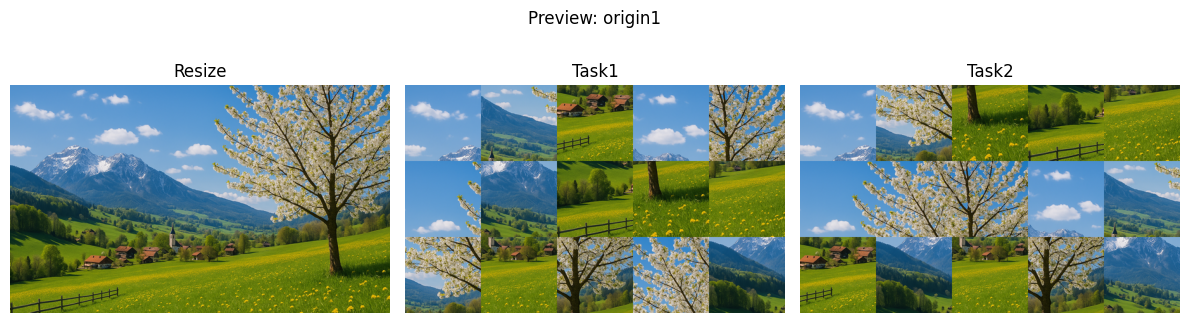

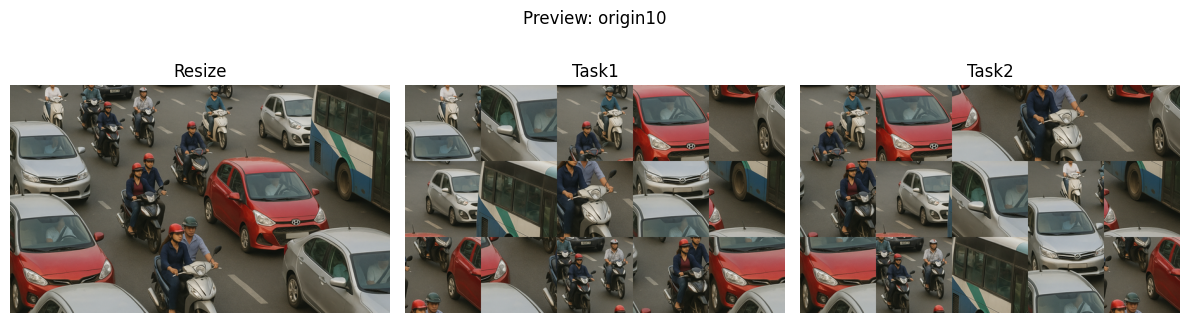

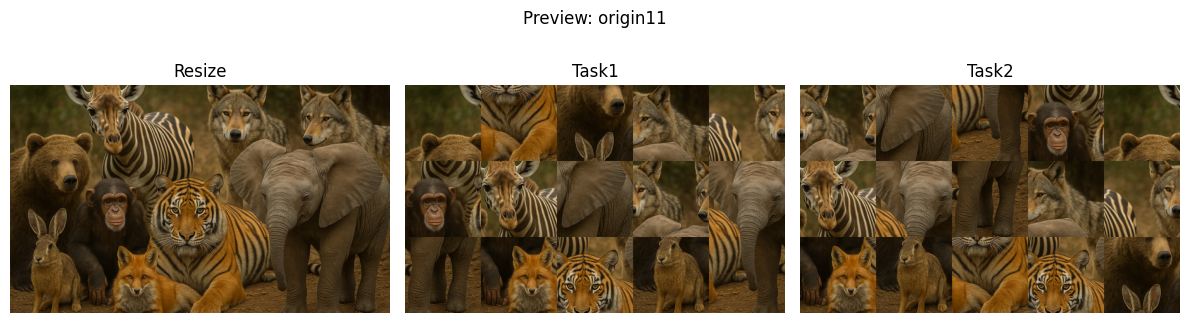

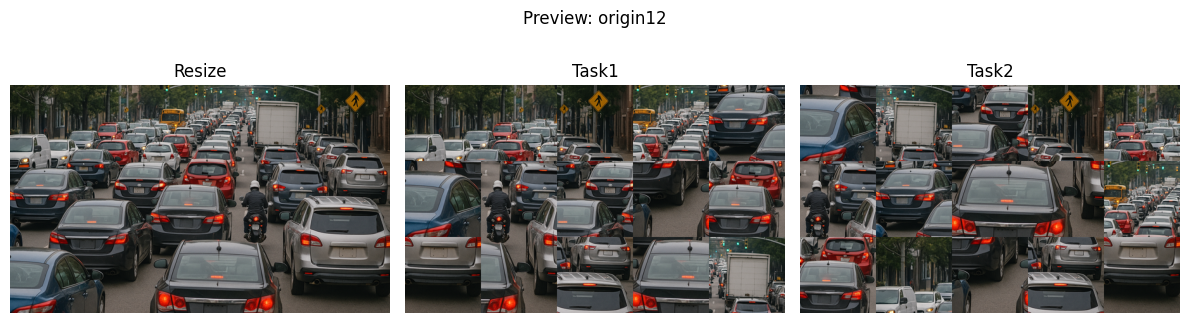

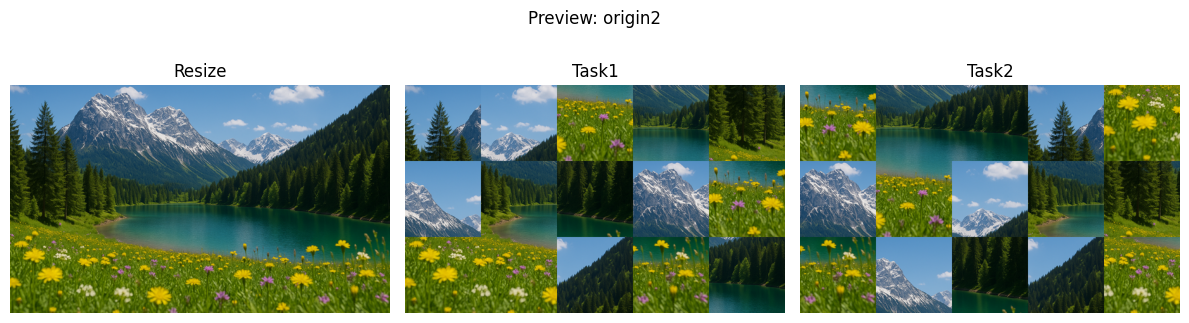

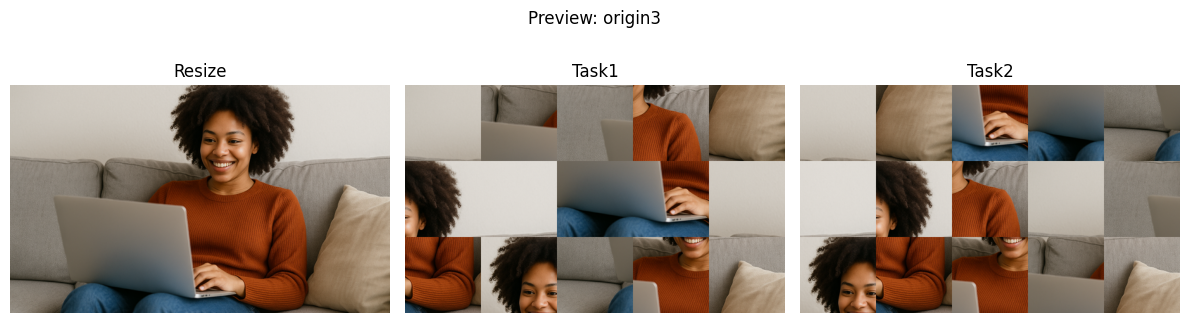

In [6]:
# ====================
# Cell 6 — Chạy pipeline
# ====================
# 1) Đặt ảnh gốc vào images/origin/
# 2) Chạy cell này để tạo:
#    - images/resize/
#    - images/problem/task1/   (giữ (0,0))
#    - images/problem/task2/   (random all)
#    - output/permutations/    (metadata hoán vị)
#    - Preview nhiều ảnh (triptych)

results = process_all(
    resize_mode="fill_crop",
    deterministic_per_image=False,  # ← MỖI LẦN CHẠY KHÁC NHAU
    preview=True,
    preview_mode="triptych",        # hoặc "resize" | "task1" | "task2"
    preview_max=6,
    preview_per_row=3,
    run_seed=None                   # None => random theo OS entropy
)

# (Nếu cần tái lập toàn bộ lượt chạy, đặt run_seed=12345)
